In [1]:
from nldg.utils import *
from nldg.rf import MaggingRF
from adaXT.random_forest import RandomForest
from nldg.train_nn import *
from sklearn.preprocessing import StandardScaler

## GDRO

In [2]:
data_setting = 9
if data_setting == 1:
    dtr = gen_data_v2(n=1000)
elif data_setting == 2:
    dtr = gen_data_v3(n=1000, setting=2)
elif data_setting == 3:
    dtr = gen_data_v4(n_easy=500, n_hard=500)
elif data_setting == 4:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.5, noise_var_env2=10.0)
elif data_setting == 5:
    dtr = gen_data_v6(n=1000, noise_std=0.5)
elif data_setting == 6:
    dtr = gen_data_v7(n=1500)
elif data_setting == 7:
    dtr = gen_data_v8(n=1500)
elif data_setting == 8:
    dtr = gen_data_v5(n_samples=1000, adv_fraction=0.1, noise_var_env2=2.0, setting=2)
else:
    dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)

In [3]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_train_sorted = scaler.fit_transform(Xtr_sorted)

lr = 0.01 # 0.01 for second setting
seed = 42
hd = [64, 64]
wd = 0.001
epochs=1500

model, bweights = train_model_GDRO(X_train, Ytr, Etr,
                                   lr_model=lr, hidden_dims=hd,
                                   seed=seed, weight_decay=wd, epochs=epochs)
preds_gdro = predict_GDRO(model, X_train_sorted)
fitted_gdro = predict_GDRO(model, X_train)

In [4]:
bweights

tensor([9.8564e-01, 1.4308e-02, 5.2974e-05])

In [5]:
model_default = train_model(X_train, Ytr,
                            lr=lr, hidden_dims=hd,
                            seed=seed, weight_decay=wd, epochs=epochs)
preds_default = predict_default(model_default, X_train_sorted)
fitted_default = predict_default(model_default, X_train)

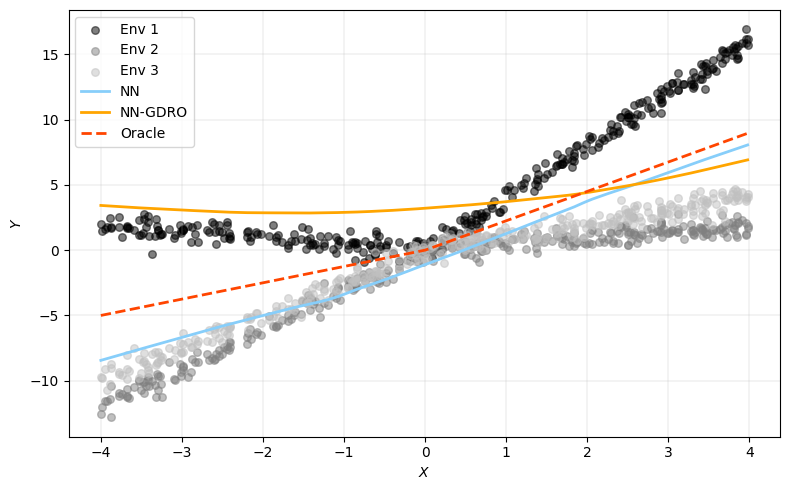

In [7]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_gdro"] = preds_gdro
dtr["fitted_default"] = preds_default

plot_dtr(dtr, gdro=True, optfun=4)

## MaxRM Random Forest

In [2]:
dtr = gen_data_v6(n=1000, noise_std=0.5, setting=2)
Xtr = np.array(dtr.drop(columns=['E', 'Y']))
Ytr = np.array(dtr['Y'])
Etr = np.array(dtr['E'])
Xtr_sorted = np.sort(Xtr, axis=0)
n_estimators = 50
min_samples_leaf = 30
random_state = 42

dte = gen_data_v6(n=1000, noise_std=0.5, random_state=42, setting=2)
Xte = np.array(dte.drop(columns=["E", "Y"]))
Yte = np.array(dte["Y"])
Ete = np.array(dte["E"])

#### RF

In [3]:
rf = RandomForest(
    "Regression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
)
rf.fit(Xtr, Ytr)
fitted_rf = rf.predict(Xte)
preds_rf = rf.predict(Xtr_sorted)
max_mse(Yte, fitted_rf, Ete, verbose=True)

Environment 0 MSE: 25.055145217894687
Environment 1 MSE: 9.26349195836476
Environment 2 MSE: 3.5897816767330646


np.float64(25.055145217894687)

#### RF - magging

In [4]:
rf_magging = MaggingRF(
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    random_state=random_state,
    backend='adaXT',
)
_ = rf_magging.fit(Xtr, Ytr, Etr)
wmag = rf_magging.get_weights()
fitted_magging = rf_magging.predict(Xte)
preds_magging = rf_magging.predict(Xtr_sorted)
max_mse(Yte, fitted_magging, Ete, verbose=True)

Environment 0 MSE: 33.71309598902495
Environment 1 MSE: 5.2957794618437415
Environment 2 MSE: 1.487742332074125


np.float64(33.71309598902495)

#### MaxRM - local

In [5]:
rf_l_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="base",
)
rf_l_mmrf.fit(Xtr, Ytr, Etr)
fitted_l_mmrf = rf_l_mmrf.predict(Xte)
preds_l_mmrf = rf_l_mmrf.predict(Xtr_sorted)
max_mse(Yte, fitted_l_mmrf, Ete, verbose=True)

Environment 0 MSE: 15.758736995339996
Environment 1 MSE: 18.500445844453324
Environment 2 MSE: 10.041638991653437


np.float64(18.500445844453324)

#### MaxRM - posthoc

In [6]:
rf.modify_predictions_trees(Etr)
fitted_post_rf = rf.predict(Xte)
preds_post_rf = rf.predict(Xtr_sorted)
max_mse(Yte, fitted_post_rf, Ete, verbose=True)

Environment 0 MSE: 16.55721457860687
Environment 1 MSE: 15.807221397806314
Environment 2 MSE: 7.931262787596784


np.float64(16.55721457860687)

#### MaxRM - posthoc local

In [7]:
rf_l_mmrf.modify_predictions_trees(Etr)
fitted_post_l_mmrf = rf_l_mmrf.predict(Xte)
preds_post_l_mmrf = rf_l_mmrf.predict(Xtr_sorted)
max_mse(Yte, fitted_post_l_mmrf, Ete, verbose=True)

Environment 0 MSE: 16.435106269142626
Environment 1 MSE: 15.948672519980665
Environment 2 MSE: 8.024746233876286


np.float64(16.435106269142626)

#### MaxRM - global dfs

In [8]:
rf_g_dfs_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="fullopt",
)
rf_g_dfs_mmrf.fit(Xtr, Ytr, Etr)
fitted_g_dfs_mmrf = rf_g_dfs_mmrf.predict(Xte)
preds_g_dfs_mmrf = rf_g_dfs_mmrf.predict(Xtr_sorted)
max_mse(Yte, fitted_g_dfs_mmrf, Ete, verbose=True)

Environment 0 MSE: 16.44192139191696
Environment 1 MSE: 15.931584304910858
Environment 2 MSE: 8.02121236261567


np.float64(16.44192139191696)

#### MaxRM - global

In [9]:
rf_g_mmrf = RandomForest(
    "MinMaxRegression",
    n_estimators=n_estimators,
    min_samples_leaf=min_samples_leaf,
    seed=random_state,
    minmax_method="adafullopt",
)
rf_g_mmrf.fit(Xtr, Ytr, Etr)
fitted_g_mmrf = rf_g_mmrf.predict(Xte)
preds_g_mmrf = rf_g_mmrf.predict(Xtr_sorted)
max_mse(Yte, fitted_g_mmrf, Ete, verbose=True)

Environment 0 MSE: 16.507739396008752
Environment 1 MSE: 15.853536987919306
Environment 2 MSE: 7.965957008976633


np.float64(16.507739396008752)

#### Plot

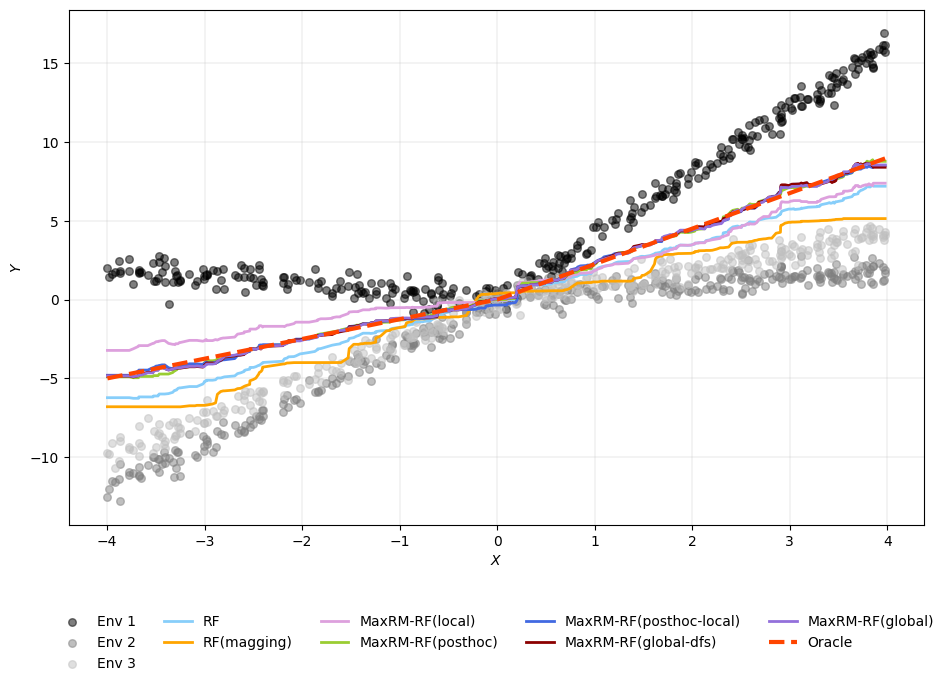

In [10]:
dtr["X_sorted"] = Xtr_sorted
dtr["fitted_rf"] = preds_rf
dtr["fitted_magging"] = preds_magging
dtr["fitted_l_mmrf"] = preds_l_mmrf
dtr["fitted_post_rf"] = preds_post_rf
dtr["fitted_post_l_mmrf"] = preds_post_l_mmrf
dtr["fitted_g_dfs_mmrf"] = preds_g_dfs_mmrf
dtr["fitted_g_mmrf"] = preds_g_mmrf

plot_dtr_all_methods(dtr, optfun=4, saveplot=True, nameplot="setting9_allmethods")